## Approch-1: Lane detection using Hough Transform

In this approch i have used opencv as core component and found the lane line. This approch did not used any deep learning algorithm instead used a simple hough transform line dection algorithm which serves the purpose.

Before applyting the hough transform algorithm certain prepocessing steps are used. The overall process consist of the following steps :

##### Step 1 : Color Selection

##### Step 2 : Canny Edge Detection

##### Step 3 : Region of Interest Selection

##### Step 4 : Hough Transform Line Detection

lets start with the steps by step :

#### ** pre-processing : Loading the Test images

In [7]:
# import libaries

import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# used to display images 

def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

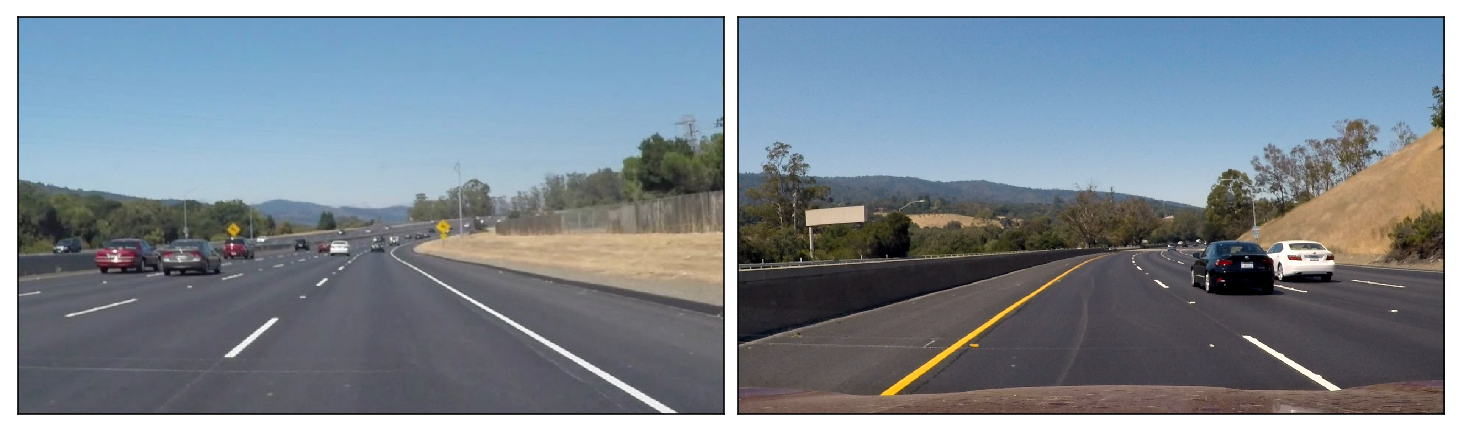

In [9]:
# plot the test images

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

#### Step 1 : Color Selection

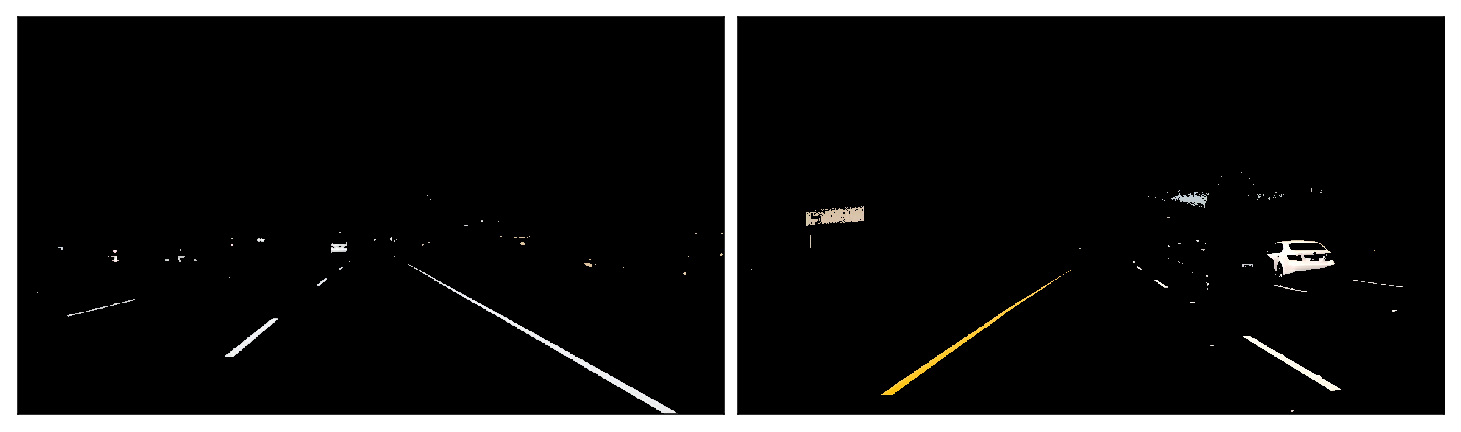

In [10]:
# selecting only yellow and white colors in the images using the RGB channels 

def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

show_images(list(map(select_rgb_white_yellow, test_images)))

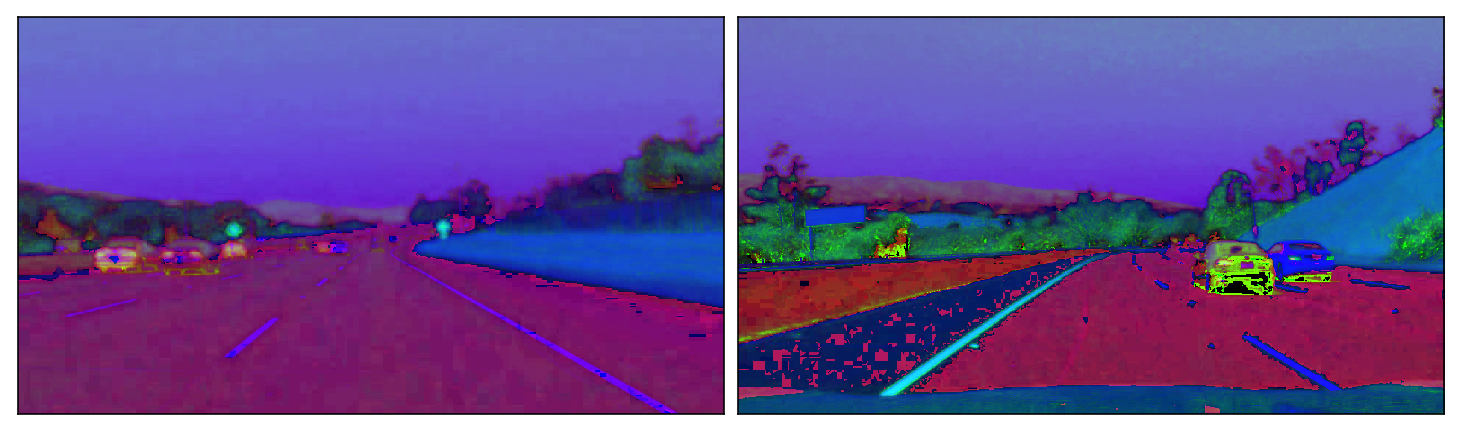

In [12]:
# RGB images are converted into HSV color space

def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, test_images)))

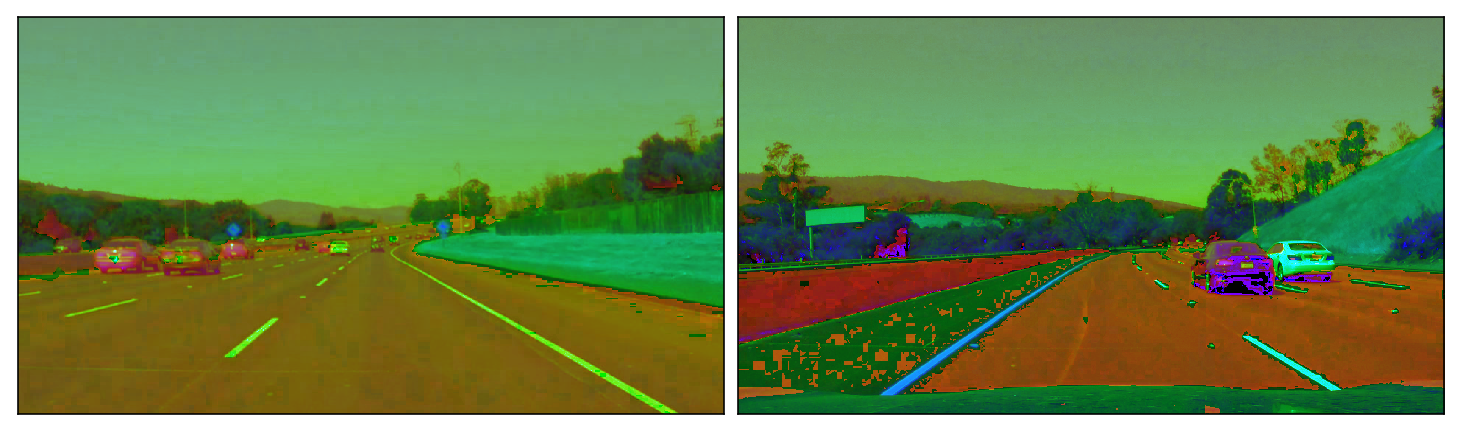

In [14]:
# RGB images are converted into HSL color space

def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hsl, test_images)))

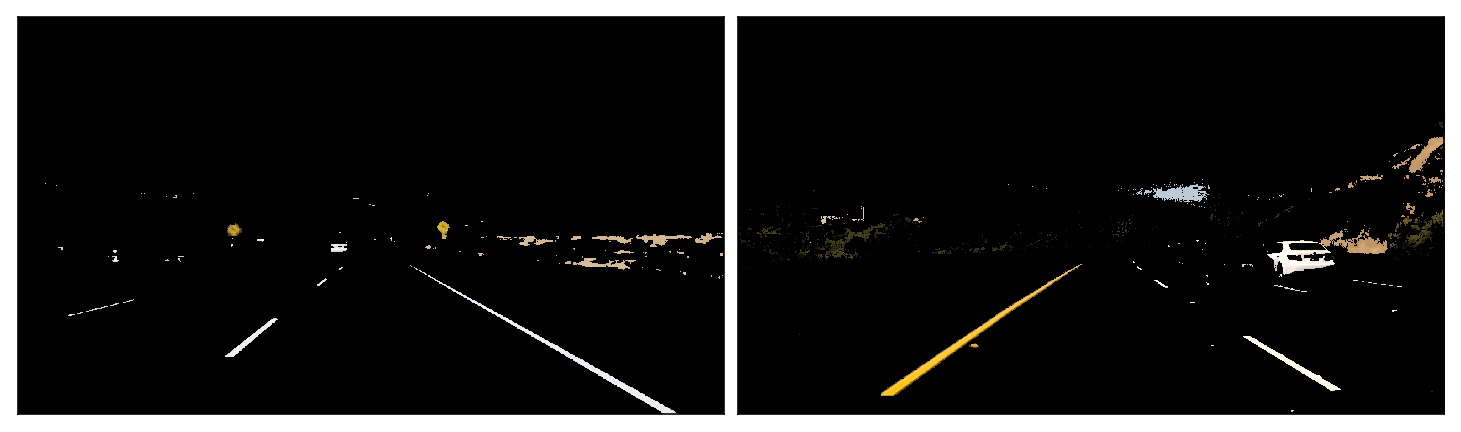

In [15]:
# filter to select those white and yellow lines

def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, test_images))

show_images(white_yellow_images)

#### Step 2 : Canny Edge Detection : canny edge detector for detecting edges in order to find lane lines


#### 2.1) Gray Scaling : converting into gray scaled in order to detect shapes in images

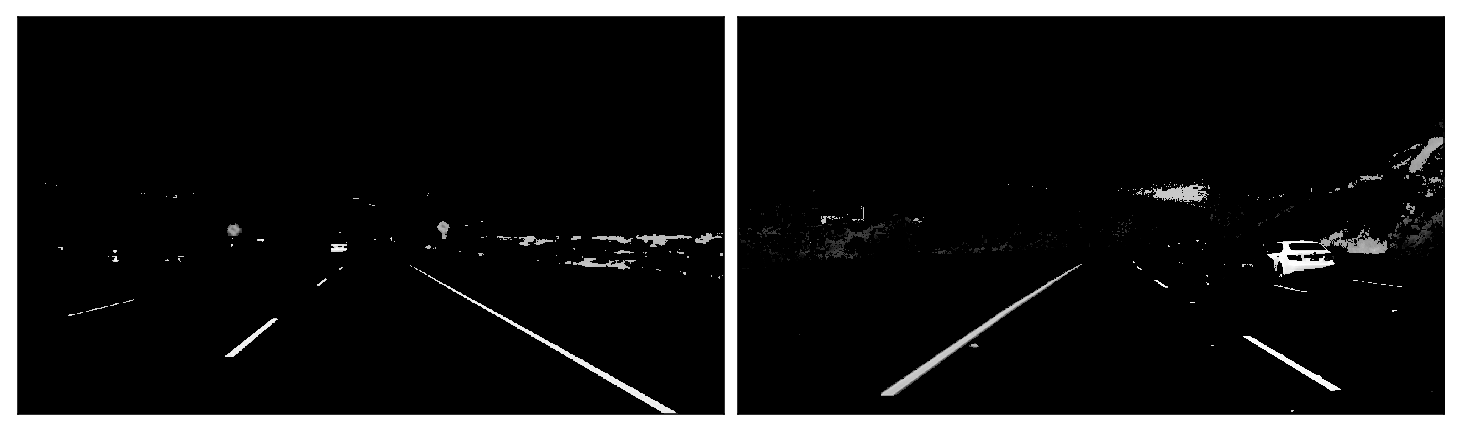

In [19]:
# gray scaling

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

#### 2.2) Gaussian Smoothing (Gaussian Blur) : making the edges smoother

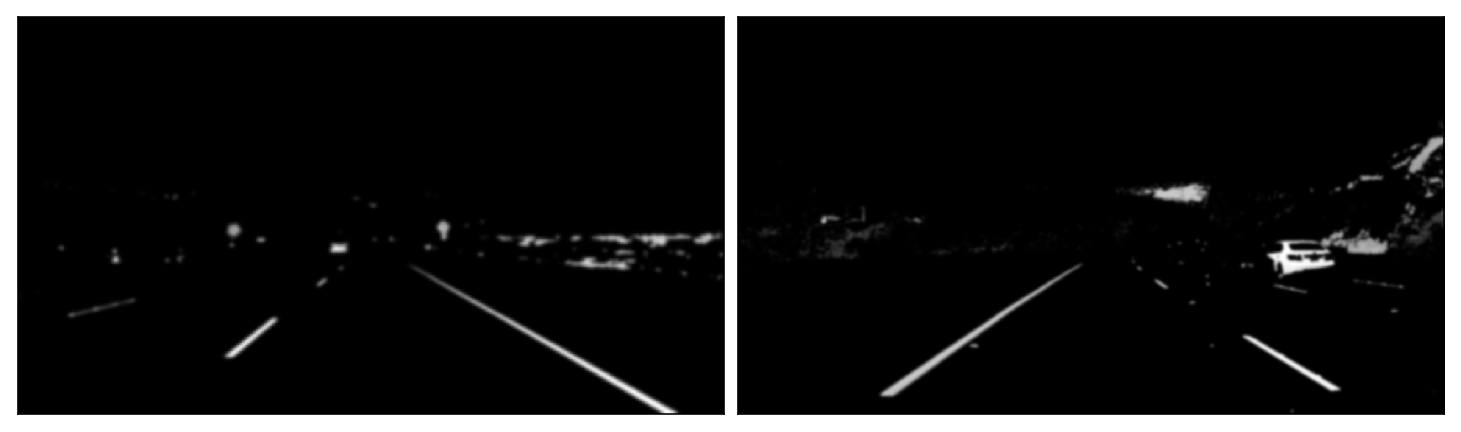

In [22]:
# Gaussian Smoothing

def apply_smoothing(image, kernel_size=15):
    
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

#### 2.3) Edge Detection : detecting edges in images

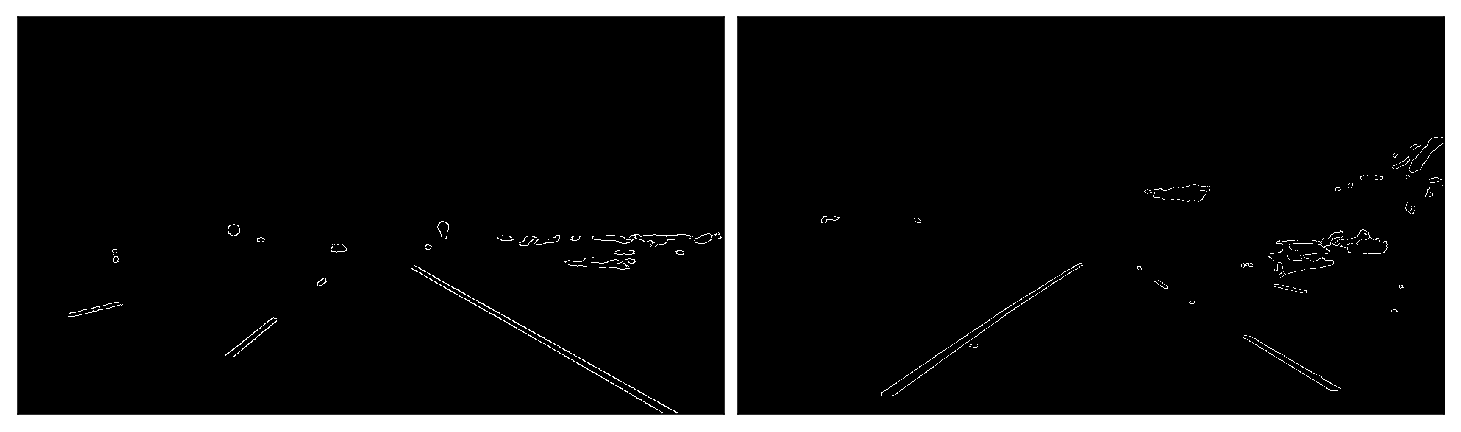

In [23]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

##### Step 3 : Region of Interest Selection :  selecting only region of interest

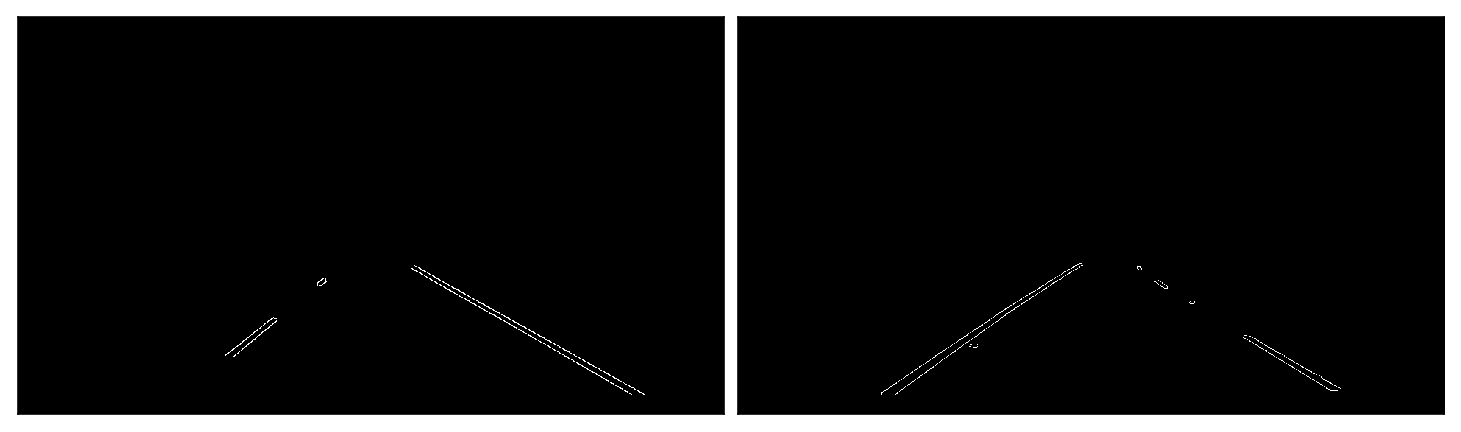

In [24]:
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

##### Step 4 : Hough Transform Line Detection :  detect lines in the edge images

In [26]:
def hough_lines(image):

    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

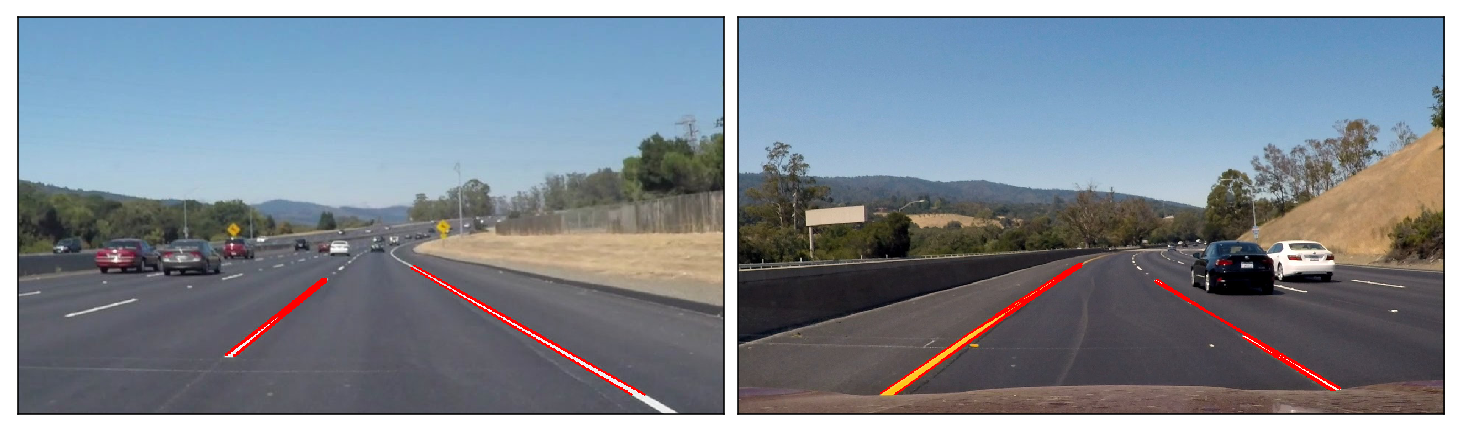

In [27]:
# draw lines on actutal image

def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

In [28]:
### Averaging and Extrapolating Lines : averaged multiple lines detected for a lane line

def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)


In [29]:
#   Convert a line represented in slope and intercept into pixel points

def make_line_points(y1, y2, line):

    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

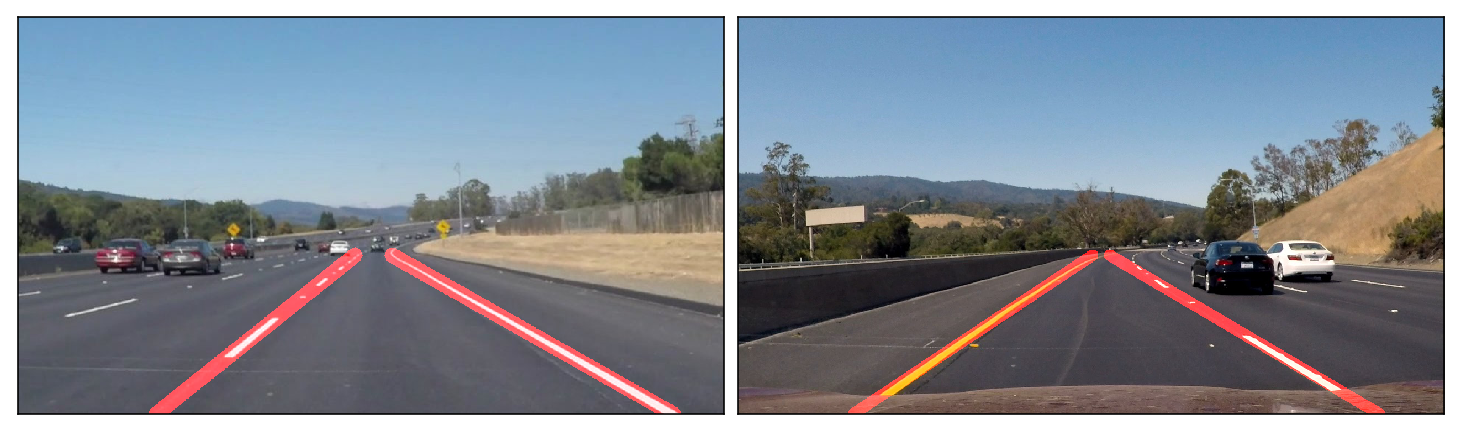

In [31]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)